In [19]:
import numpy as np
import pandas as pd
import os

from sklearn.cluster import KMeans

from scipy import stats

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)

## Aggregate all data into single Data Frame

In [2]:
from os import listdir
from os.path import isfile, join
path_train = 'ignored_assets/public_data/training_data/order_data'
trainfiles = [f for f in listdir(path_train) if isfile(join(path_train, f)) and f != '.DS_Store']

path_test1 = 'ignored_assets/public_data/test_set_1/order_data'
testfiles1 = [f for f in listdir(path_test1) if isfile(join(path_test1, f)) and f != '.DS_Store']

path_test2 = 'ignored_assets/public_data/test_set_2/order_data'
testfiles2 = [f for f in listdir(path_test2) if isfile(join(path_test2, f)) and f != '.DS_Store']

In [8]:
orderdf = []
for f in trainfiles:
    orderdf.append(pd.read_csv(join(path_train, f), delimiter='\t', header = None))
    
for f in testfiles1:
    orderdf.append(pd.read_csv(join(path_test1, f), delimiter='\t', header = None))
    
for f in testfiles2:
    orderdf.append(pd.read_csv(join(path_test2, f), delimiter='\t', header = None))


orderdf = pd.concat(orderdf)

In [9]:
orderdf.columns = ['order_id', 'driver_id', 'passenger_id', 'start_district_hash', 'dest_district_hash', 'price', 'timestamp']
orderdf['timestamp'] = pd.to_datetime(orderdf['timestamp'])

## Obtain driver clusters and label drivers

In [11]:
orderdf['hour'] = orderdf['timestamp'].dt.hour
orderdf['dayofweek'] = orderdf['timestamp'].dt.dayofweek

In [12]:
bigtable = pd.pivot_table(orderdf, index = ['hour'], columns=['driver_id'], values = ['order_id'],aggfunc=len)

In [13]:
sample = bigtable.fillna(0).as_matrix().T
nclusters = 5
kmeans = KMeans(n_clusters=nclusters, random_state=0).fit(sample)

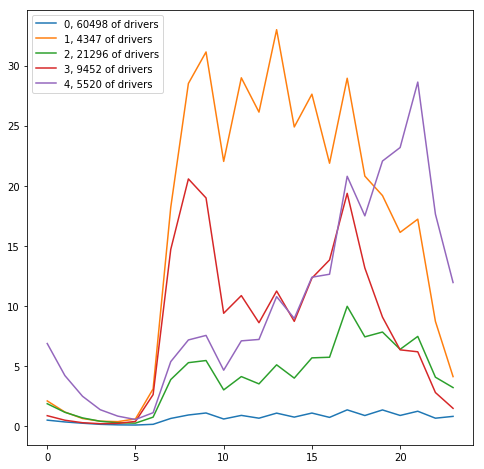

In [14]:
for i in range(nclusters):
    plt.plot(kmeans.cluster_centers_[i], label=str(i) + ', ' + str(np.sum(kmeans.labels_ == i)) + ' of drivers')

plt.legend()

In [15]:
match = {did[1]: kmeans.labels_[i] for i,did in enumerate(bigtable.columns)}

In [16]:
def assign_driver_label(dids):
    labels = np.zeros(len(dids), dtype=object)
    for i,did in enumerate(dids):
        if pd.isnull(did):
            labels[i] = np.nan
        else:
            labels[i] = match[did]
    return labels
    

In [17]:
orderdf['driver_cluster'] = assign_driver_label(orderdf['driver_id'])

## Obtain travel time for each ride

In [18]:
# [time, distance, cost]

D = np.array([
    [24., 15.2, 68.57],
    [14., 11.7, 53.75],
    [20., 18.2, 75.16],
    [50., 40.5, 152.44],
    [49., 48.8, 174.97],
    [8, 2.7, 25.42],
    [13, 9.4, 47.03]
], dtype=np.float64)

In [20]:
slope, intercept, r_value, p_value, std_err = stats.linregress(D[:,0],(D[:,2] - 14)*0.6666)

In [21]:
orderdf['expected_travel_time'] = orderdf['price'] / slope

In [22]:
orderdf['expected_travel_time'].mean()

8.077747978871562

## Push the new dataset to BigQuery